In [1]:
from utils import *
from blob import *

Let us vizualize one map of values with one generated blob

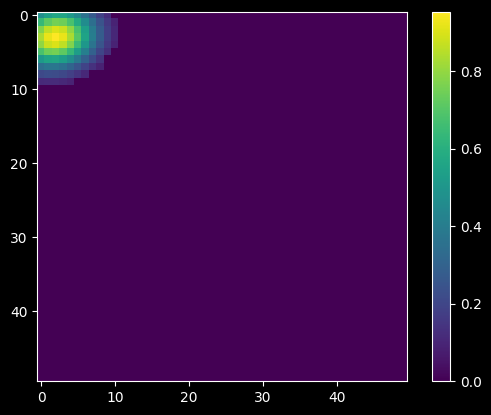

In [2]:
blob = Blob(grid_length=50)
blob_values = blob.get_blob_map(grid_length=50)
plt.imshow(blob_values)
plt.colorbar()

Now, create all the global latent maps

In [3]:
def create_latent_maps(grid_length=50):
    latent_global_maps = []
    centers_to_avoid = []
    all_blobs = [] #list of lists, each containing the blobs of a latent map
    k = 5
    for numMap in range(k):
        blobs, centers_to_avoid = get_random_blobs(grid_length=50, max_blobs=3, centers_to_avoid=centers_to_avoid)
        latent_global_maps.append(generate_global_map(grid_length=50, blobs=blobs))
        all_blobs.append(blobs)
    latent_global_maps = np.array(latent_global_maps)
    return latent_global_maps

In [4]:
latent_global_maps = []
centers_to_avoid = []
all_blobs = [] #list of lists, each containing the blobs of a latent map
k = 5
for numMap in range(k):
    blobs, centers_to_avoid = get_random_blobs(grid_length=50, max_blobs=3, centers_to_avoid=centers_to_avoid, dist_between_blobs=12)
    latent_global_maps.append(generate_global_map(grid_length=50, blobs=blobs))
    all_blobs.append(blobs)
latent_global_maps = np.array(latent_global_maps)
latent_global_maps.shape

/Users/jeandmr/Documents/MVA/Semestre 1/Machine Learning for Time Series/Project/project-mva-time-series/blob.py:94: RuntimeWarning: invalid value encountered in sqrt
  min_dist = np.min([np.sqrt(np.sum(existing_center **2 - center_new_blob**2)) for existing_center in centers_to_avoid])


(5, 50, 50)

Vizualization:

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_2379/2051499805.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


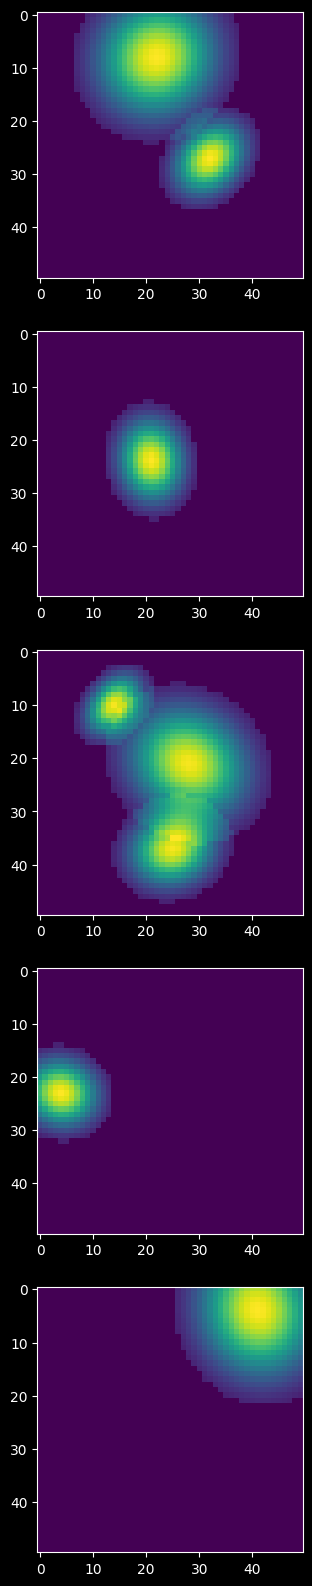

In [5]:
fig, ax = plt.subplots(k, figsize=(10, 20))
for i in range(k):
    ax[i].imshow(latent_global_maps[i, :,:])
fig.show()

In [6]:
def get_subject_blobs(all_blobs:List[List[Blob]], jitter=0, smoothness=0):
    """ 
    Returns the all_blobs list for one specific subject given the all_blobs GLOBAL list
    """
    all_subject_blobs = []
    for blob_list in all_blobs: #iterates over k the number of latent maps

        subject_blob_list = []
        for blob in blob_list: #iterates over the blobs of one specific latent map
            subject_blob = blob.get_copy() #avoid to lose info

            #add noise on both position and size of the blobs
            noise_on_width = np.random.normal(loc=0, scale=smoothness)
            if np.abs(noise_on_width) < blob.radius: #check that we don't have blob with negative radius
                subject_blob.radius += noise_on_width

            center_shift = np.random.normal(loc=0, scale=jitter, size=2).astype('int')
            
            #avoid losing blobs in the nature
            for coord in range(2):
                new_center_1d = center_shift[coord] + subject_blob.center[coord]
                nIt = 0
                while new_center_1d < 0 or new_center_1d > subject_blob.grid_length:
                    center_shift[coord] = int(center_shift[coord]/2 )
                    print(center_shift)
                    nIt +=1
                    if nIt == 3: break
            print("hello")
            subject_blob.center += center_shift

            subject_blob_list.append(subject_blob)

        all_subject_blobs.append(subject_blob_list)

    return all_subject_blobs

In [7]:
all_subject_blobs = get_subject_blobs(all_blobs, jitter=6, smoothness=2)

hello
hello
hello
hello
hello
hello
hello
hello


In [8]:
def get_maps_from_all_blobs(all_blobs):
    """
    Made to generate latent SUBJECT maps mostly
    """
    latent_subject_maps = []
    for numMap in range(k):
        latent_subject_maps.append(generate_global_map(grid_length=50, blobs=all_blobs[numMap]))
    latent_subject_maps = np.array(latent_subject_maps)
    
    return latent_subject_maps

In [9]:
latent_subject_maps = get_maps_from_all_blobs(all_subject_blobs)
latent_subject_maps.shape

(5, 50, 50)

In [10]:
nbSubjects = 4
maps_from_subjects = []
for num_subject in range(nbSubjects):
    all_subject_blobs = get_subject_blobs(all_blobs, jitter=6, smoothness=2)
    latent_subject_maps = get_maps_from_all_blobs(all_subject_blobs)
    maps_from_subjects.append(latent_subject_maps)
len(maps_from_subjects)

hello
hello
hello
hello
hello
[-1  0]
[0 0]
[0 0]
hello
hello
hello
hello
hello
hello
hello
hello
[ 0 10]
[ 0 10]
[ 0 10]
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
[-3  8]
[-1  8]
[0 8]
hello


4

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_2379/3032545269.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


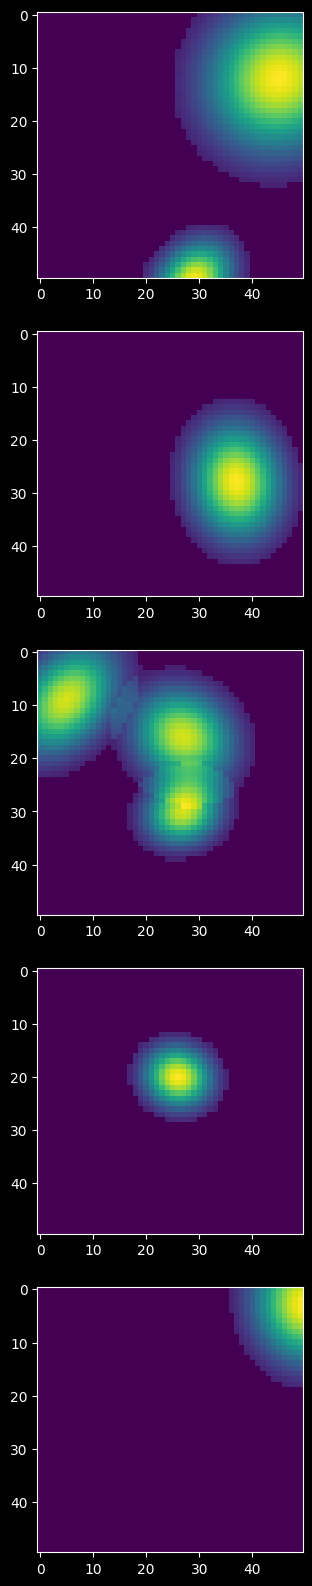

In [11]:
fig, ax = plt.subplots(k, figsize=(10, 20))
for i in range(k):
    ax[i].imshow(latent_subject_maps[i, :,:])
fig.show()

In [23]:
def generate_synthetic_fmri_data(nbSubjects, n, maps_per_subject:List[np.array], grid_length=50):
    """Generate synthetic fMRI data for multiple subjects."""
    data = np.zeros((nbSubjects, n, grid_length**2))

    for subject_idx in range(nbSubjects):
        subject_latent_maps = maps_per_subject[subject_idx] #of shape (k, grid_length, grid_length)
        k, _, _ = subject_latent_maps.shape
        subject_latent_vector = subject_latent_maps.reshape(k, grid_length**2) #careful: V_S.T in the article
        U_s = np.random.normal(loc=0, scale=2, size=(n, k))

        spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma=0.5, correlation_scale=0.5).reshape(grid_length**2)
        observations = U_s @ subject_latent_vector + spatial_noise
        data[subject_idx] = observations

    return data.reshape(nbSubjects, n, grid_length, grid_length)

In [24]:
# Parameters
time_points = 150
grid_size = 50

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(nbSubjects, time_points, maps_from_subjects)

In [25]:
synthetic_data.shape

(4, 150, 50, 50)

In [28]:
np.save("synthetic_data", synthetic_data)


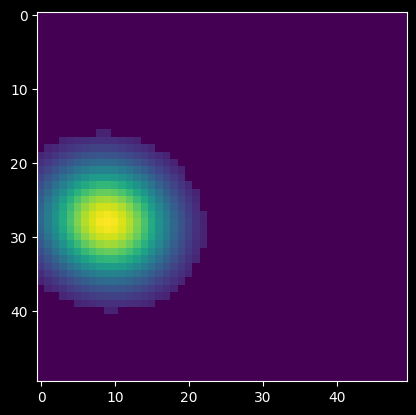

In [26]:
plt.imshow(maps_from_subjects[0][3, :, :])

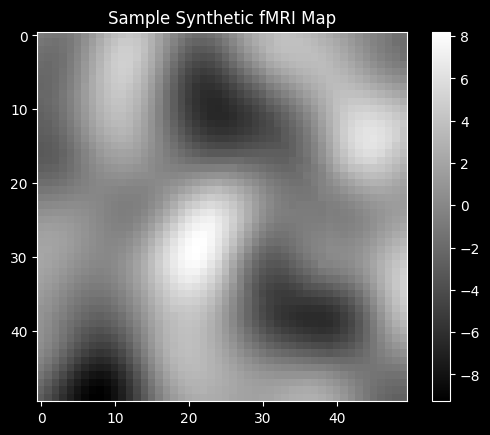

In [27]:
# Visualize one of the generated maps
plt.imshow(synthetic_data[0, 3, :, : ], cmap='gray')

plt.title("Sample Synthetic fMRI Map")
plt.colorbar()
plt.show()

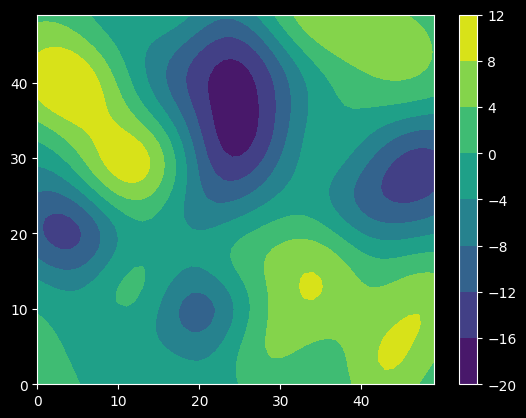

In [17]:
grid_length = 50
noise = get_random_spatially_correlated_noise(grid_length=grid_length, correlation_scale=0.5)
plt.contourf(np.arange(grid_length), np.arange(grid_length), noise)
plt.colorbar()

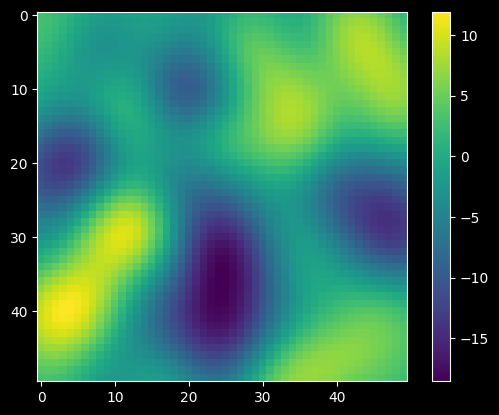

In [18]:
plt.imshow(noise)
plt.colorbar()

In [19]:
plt.imshow(generate_correlated_noise(50))

ValueError: cov must be 2 dimensional and square